In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_aligned_pic(template, filled, scale_factor = 1):


    scale_x = 170
    scale_y = 170
    scale_w = 60
    scale_h = 60

    corners_rects = [
        (260 - scale_x, 170 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y),
        (3230 - scale_x, 170 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y),  # правый верх
        (260 - scale_x, 4810 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y), # левый низ
        (3230 - scale_x, 4810 - scale_y, 100 + 1*scale_w + 2*scale_x, 100 + 1*scale_h + 2*scale_y) # правый низ

    ]
    # Создаём маску
    mask = np.zeros(template.shape[:2], dtype=np.uint8)

    # Рисуем белые прямоугольники там, где хотим искать ключевые точки
    for (x, y, w_c, h_c) in corners_rects:
        cv2.rectangle(mask, (x, y), (x+w_c, y+h_c), 255, -1)

    # Нахождение ключевых точек и дескрипторов
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(filled, None)


    # Сопоставление точек
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    print(len(matches))
    # Используем лучшие сопоставления
    good_matches = matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)


    # Вычисление матрицы гомографии
    matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Применение перспективного преобразования
    h, w = template.shape[:2]
    aligned_image = cv2.warpPerspective(filled, matrix, (w, h))

    return aligned_image

def get_contours(image):
    # Загрузка изображения

    # Инвертируем изображение (пунктирные линии должны быть белыми)
    _, binary = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY_INV)
    # print(binary.shape)

    # Применяем размытие, чтобы убрать шум
    blurred = cv2.GaussianBlur(binary, (5, 5), 0)
    # print(blurred.shape)

    # Используем морфологию для выделения прямоугольных структур
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)
    # print(processed.shape)


    # Поиск контуров
    contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: x[0][0][1])
    contours = sorted(contours, key=lambda x: x[0][0][0])
    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

    # Копия изображения для отображения результатов
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # print(output.shape)

    # Фильтруем и выделяем только прямоугольные блоки
    contours_valid = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Условие для фильтрации блоков по размеру
        if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
            contours_valid.append(contour)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return contours_valid, output

In [7]:
def remove_cells_lines(image, contours_valid):
    for contour in contours_valid:
        x, y, w, h = cv2.boundingRect(contour)
        scale = 20
        scale_2 = 5
        scale_3 = 5
        scale_4 = 10
        image[y - scale : y + scale_3, x - scale_2 : x + w + scale_2] = 255 # нижняя горизонтальная линия
        image[y + h - scale_3 : y + h + scale, x - scale_2 : x + w + scale_2] = 255 # верхняя горизонтальная лини
        image[y - scale_2 : y + h + scale_2, x - scale_4 : x + scale_4] = 255 # левая вертикальная линия
        image[y - scale_2 : y + h + scale_2, x + w - scale_4 : x + w + scale_4] = 255 # правая вертикальная линия

    return image


1380


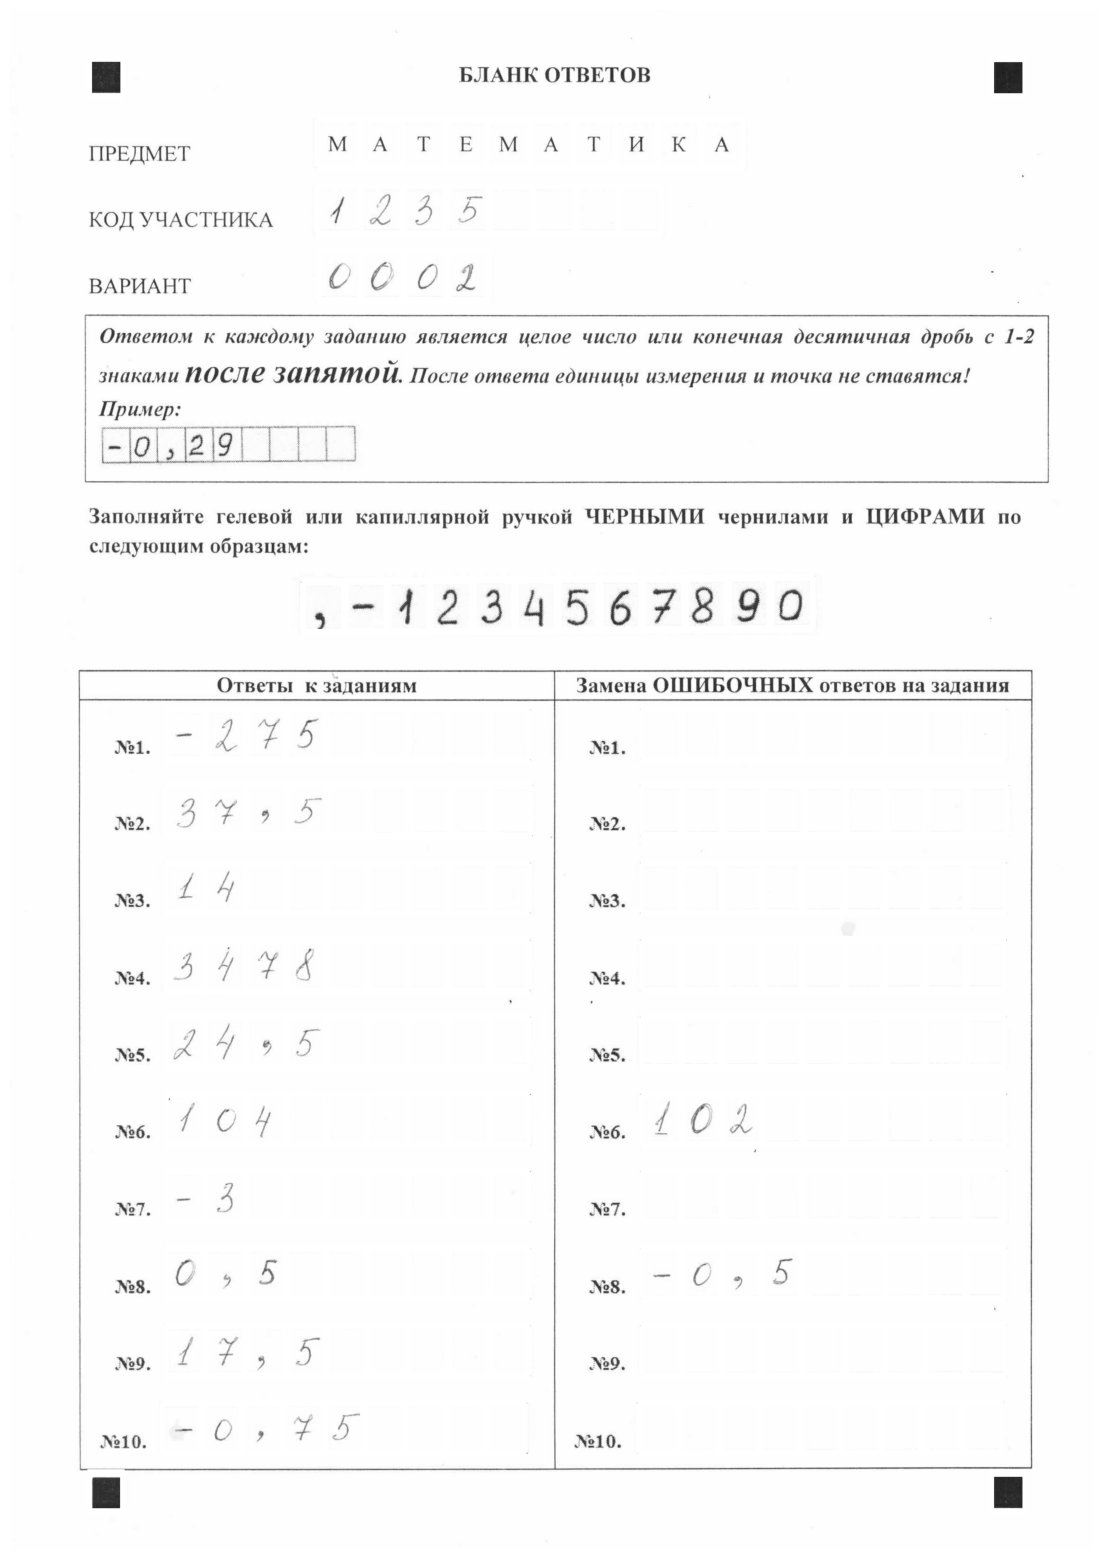

1398


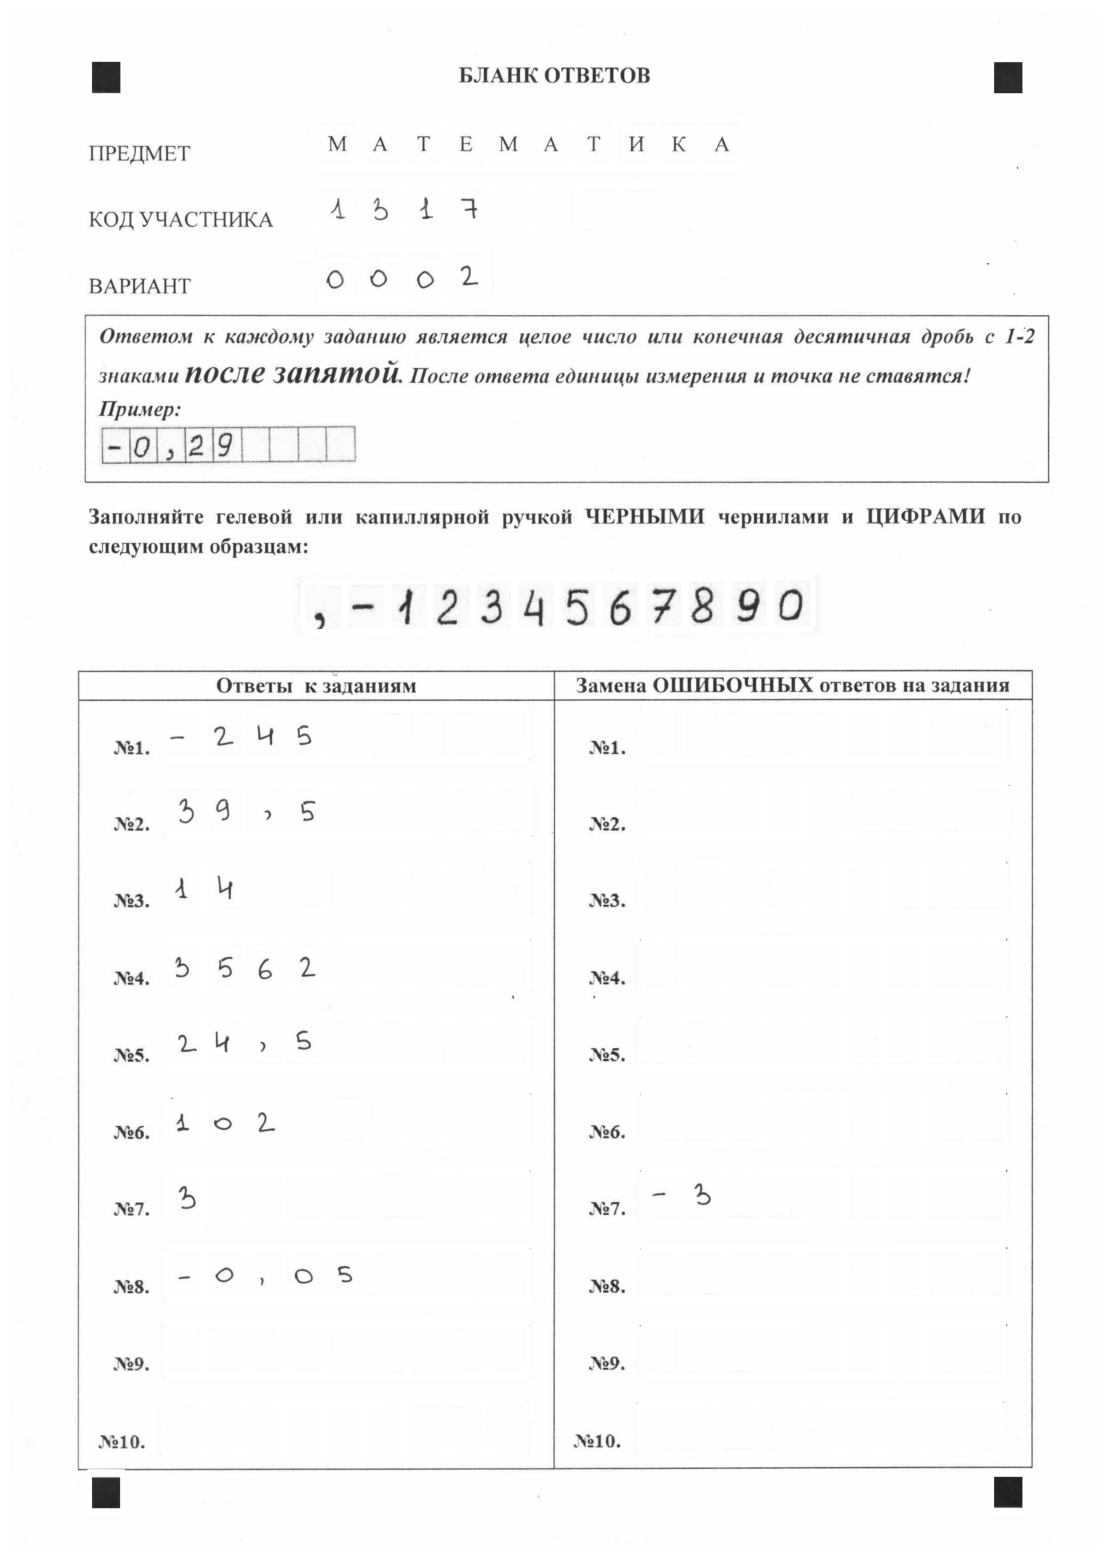

1409


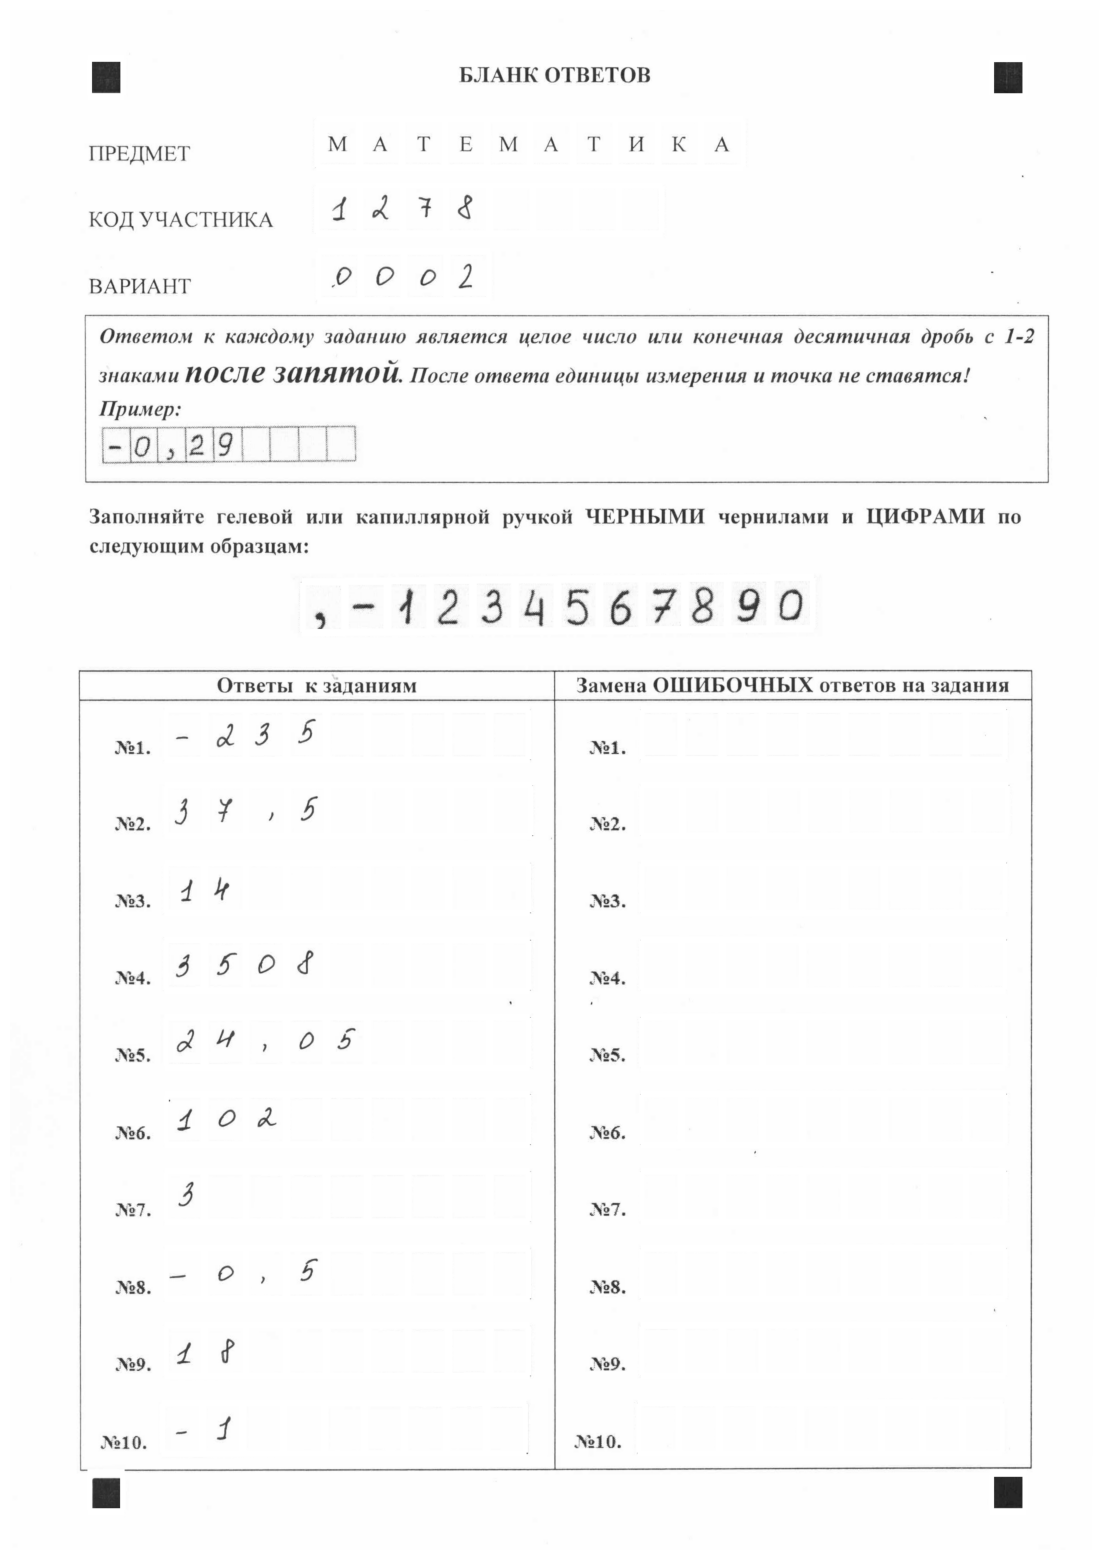

1366


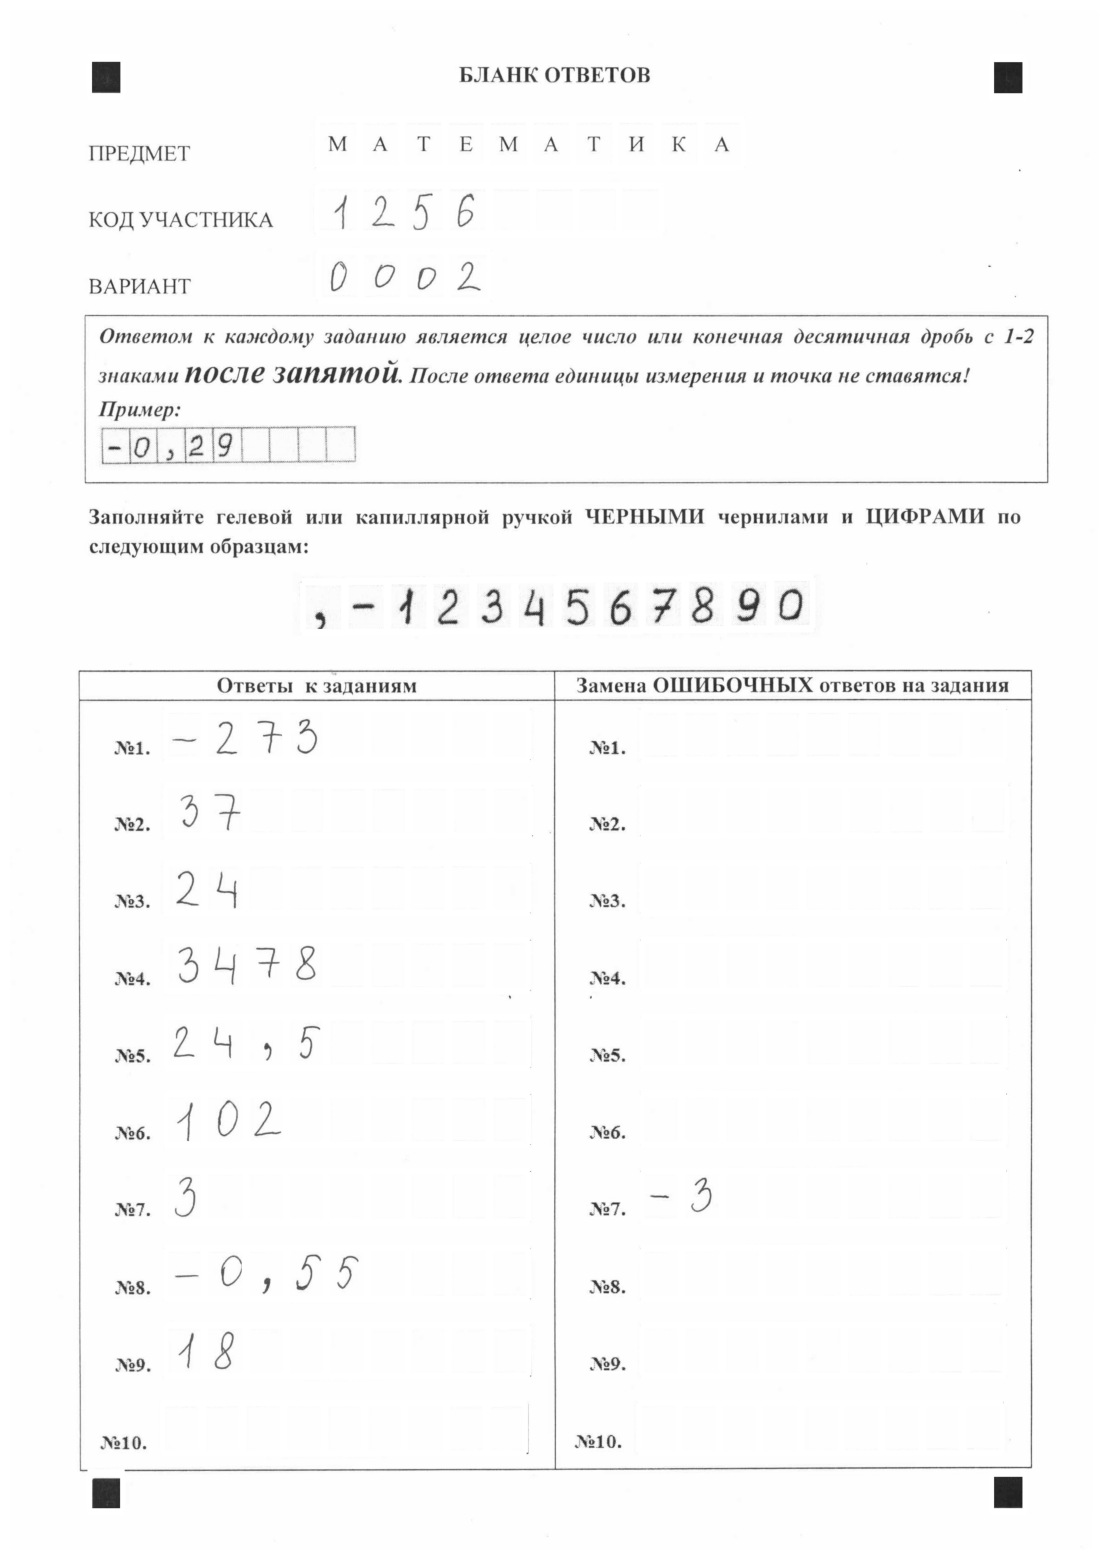

1384


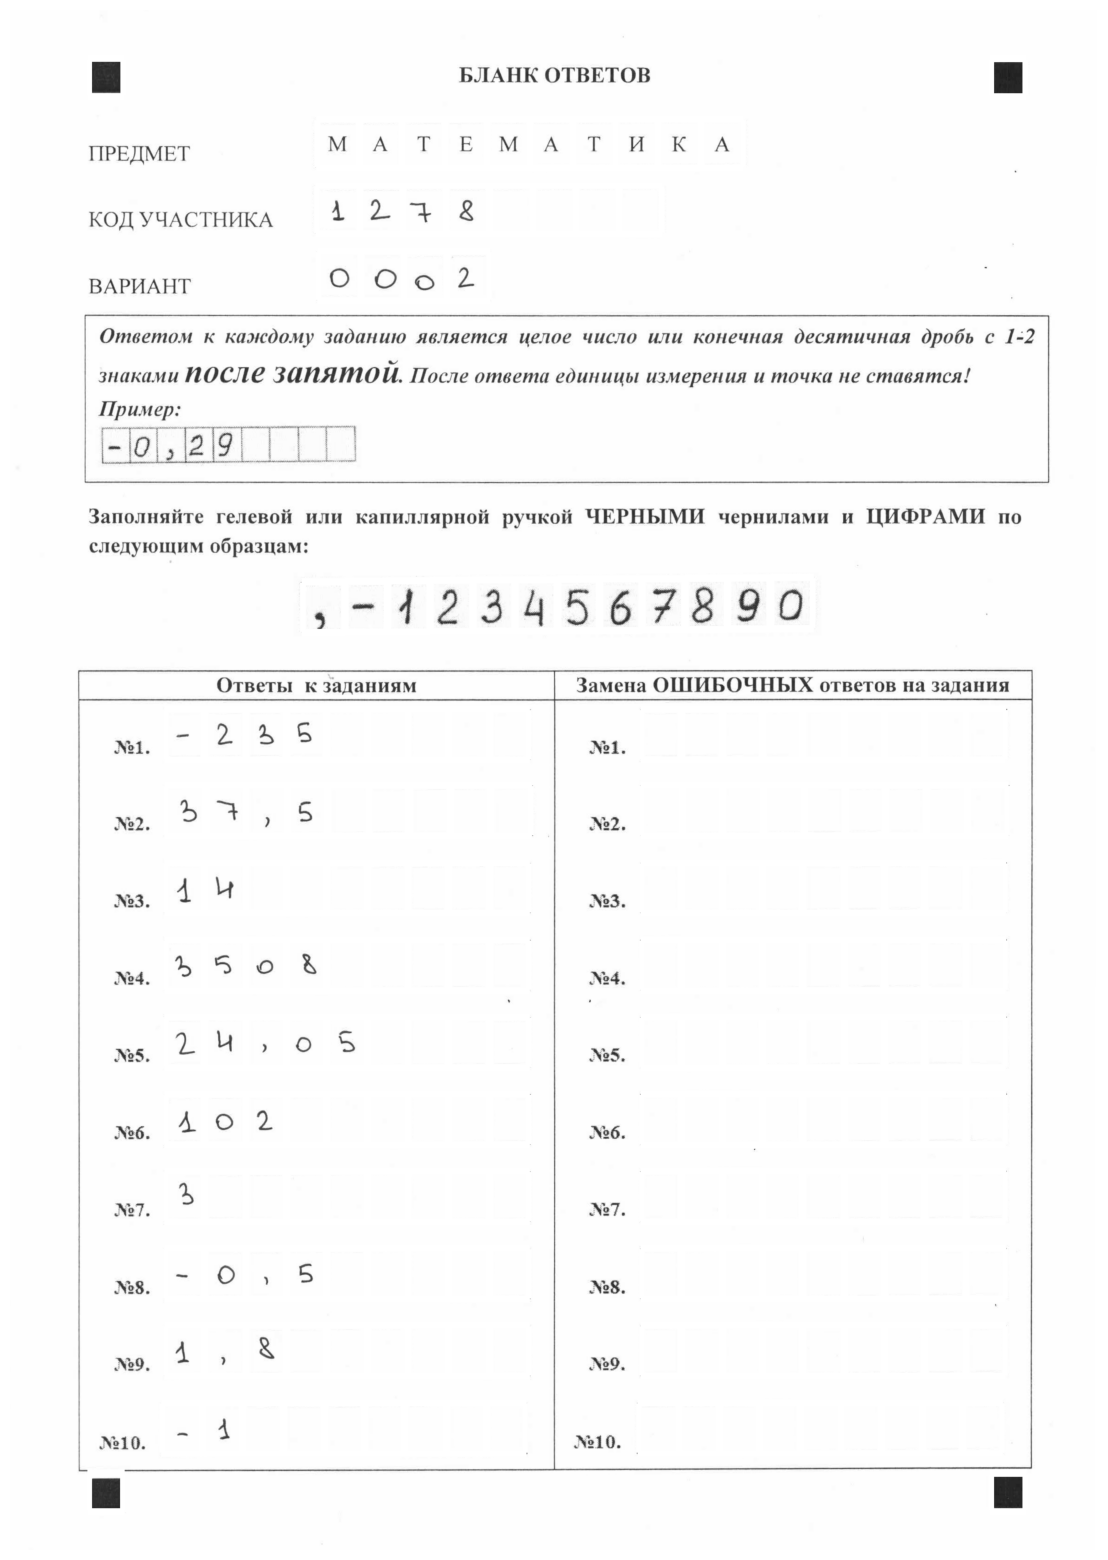

1380


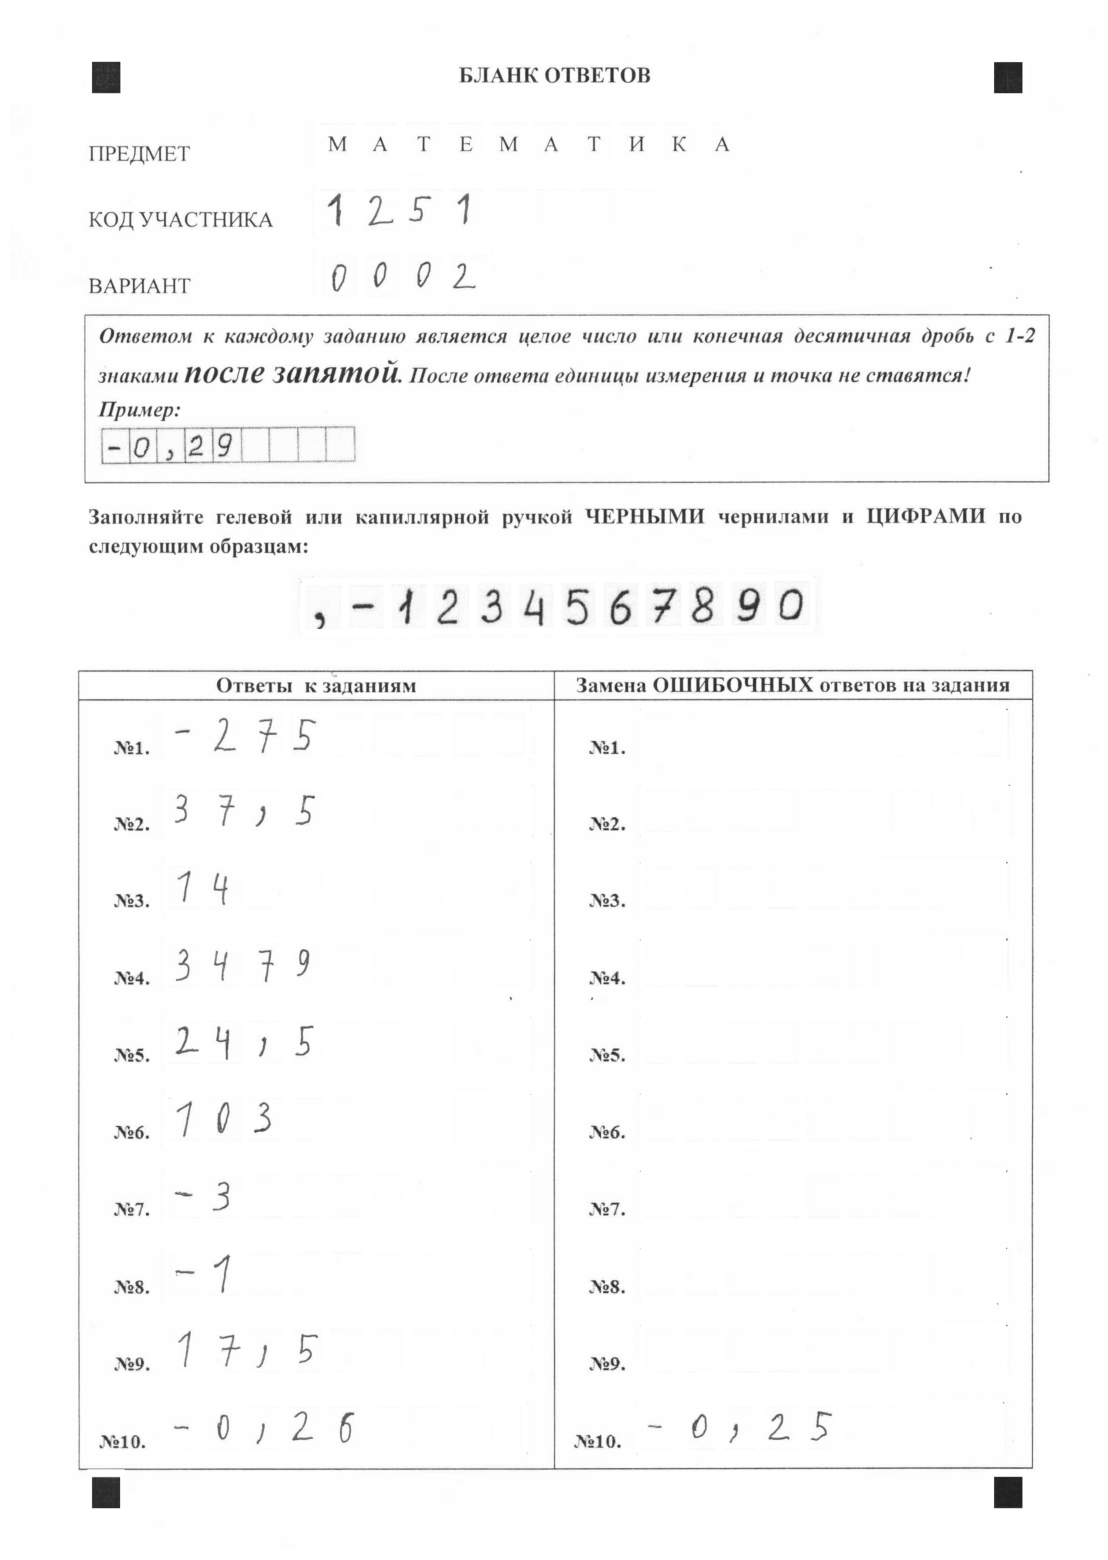

1391


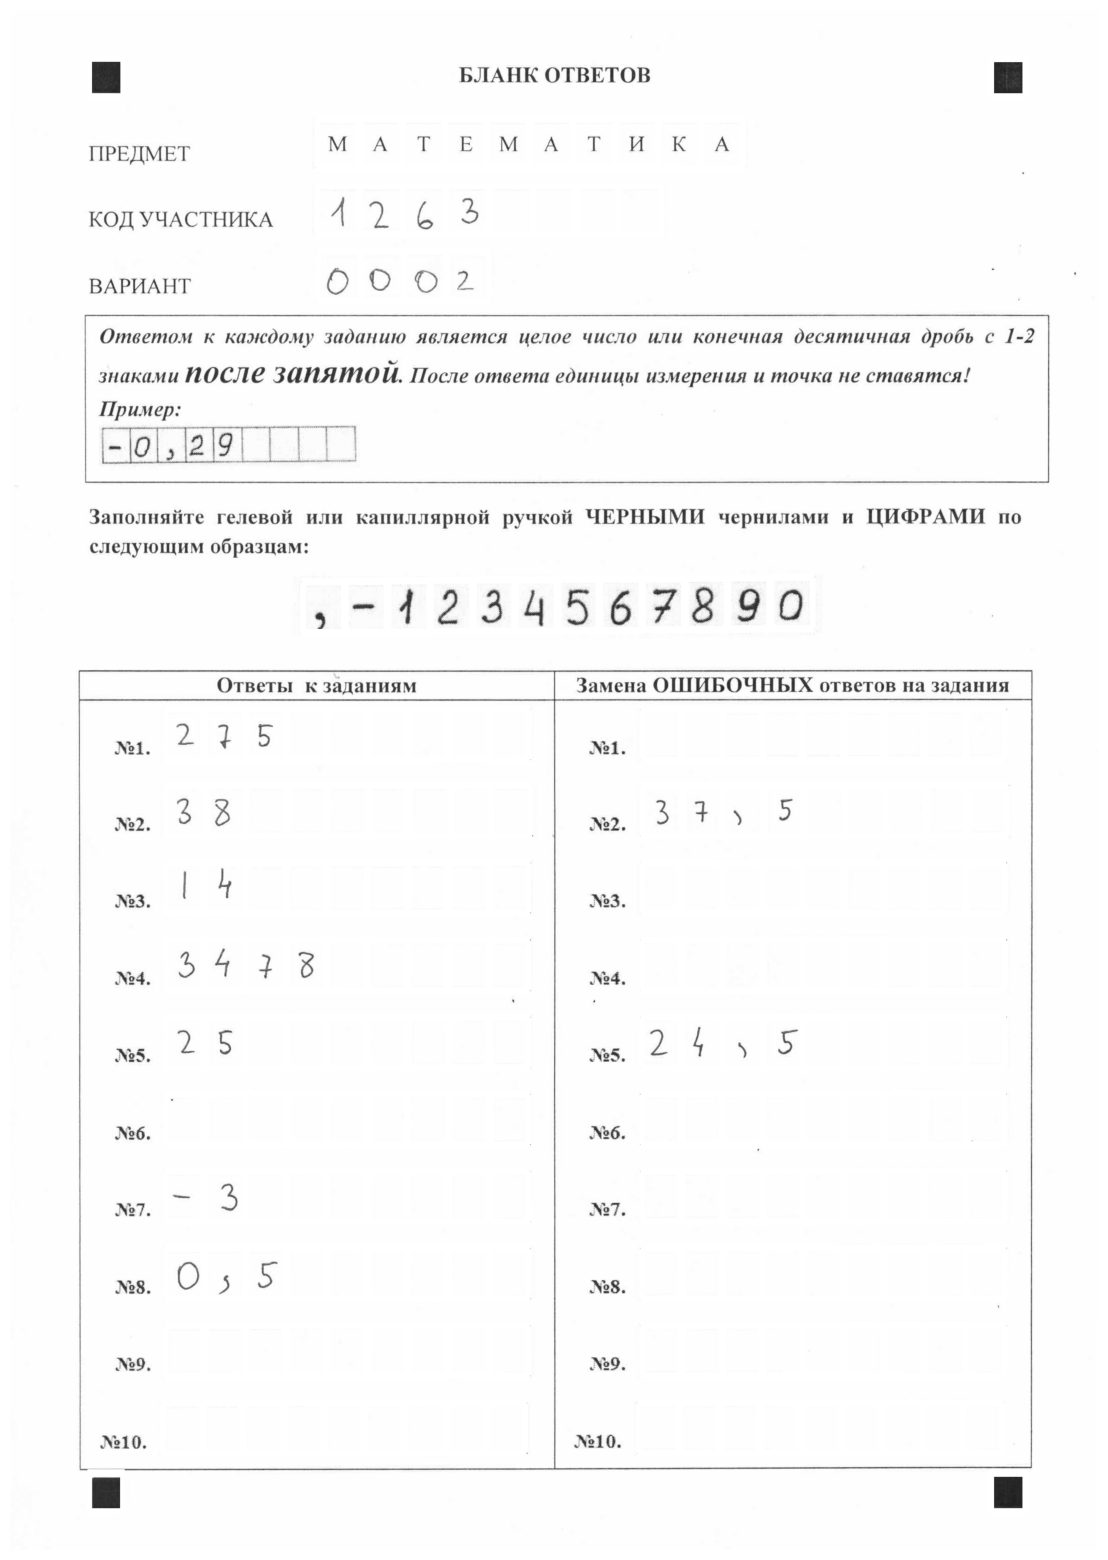

1373


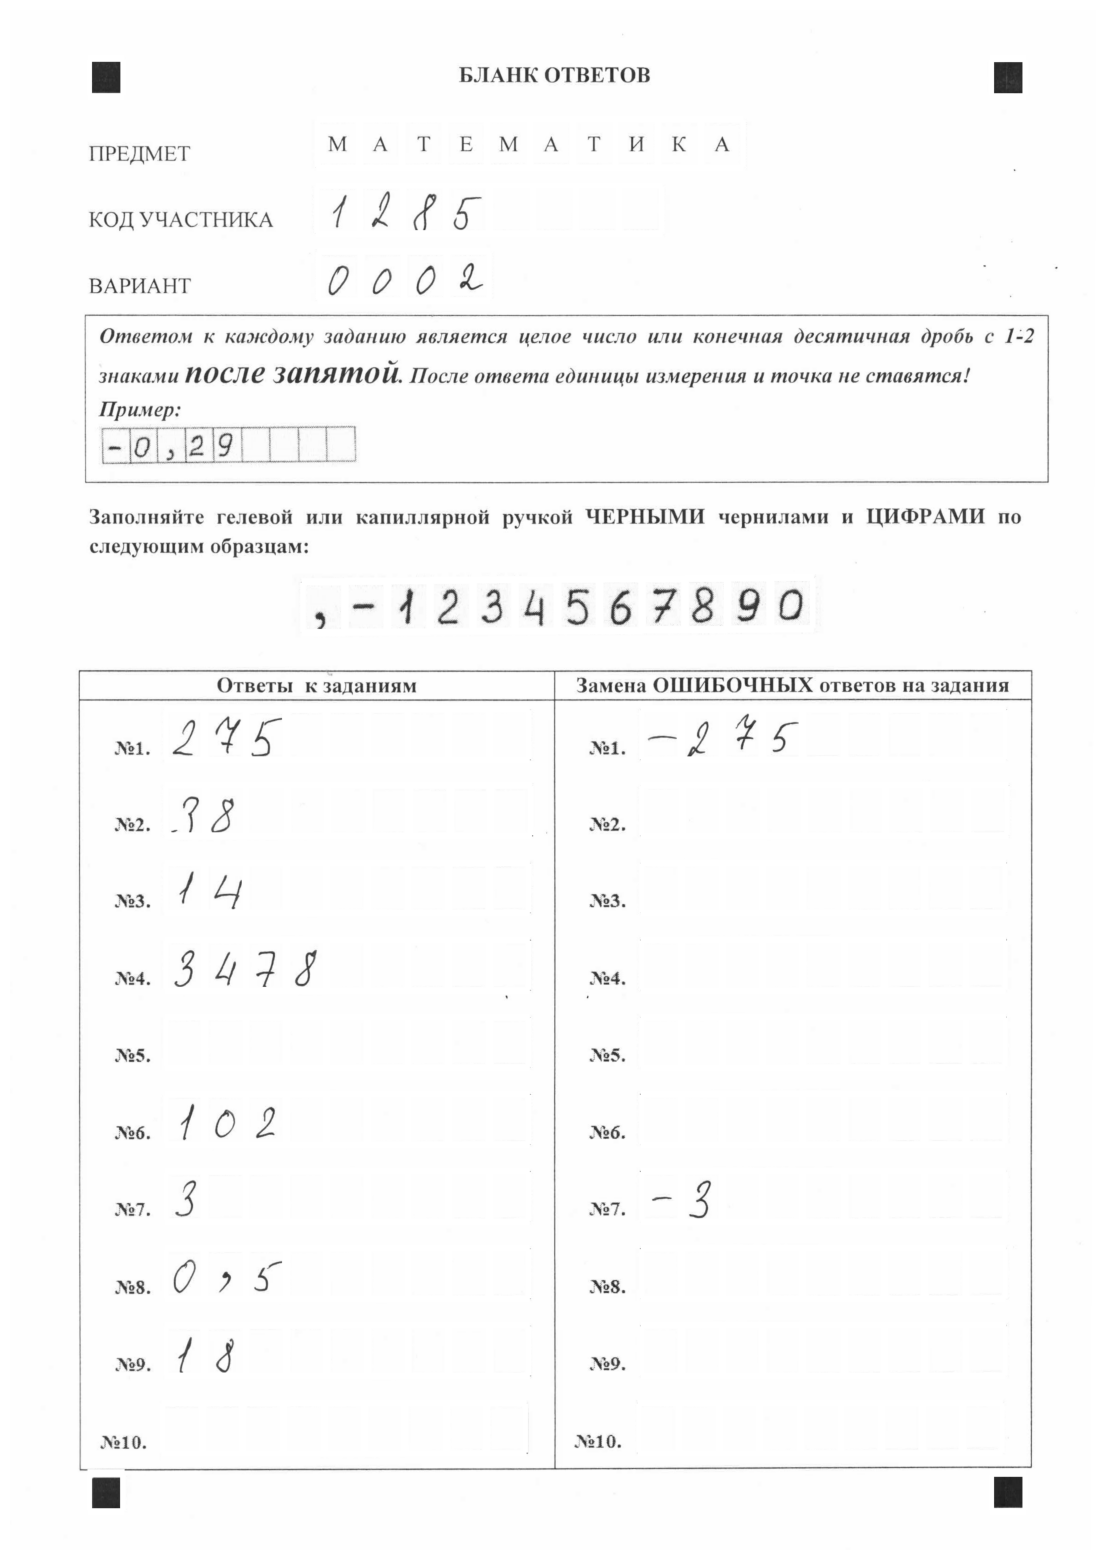

1377


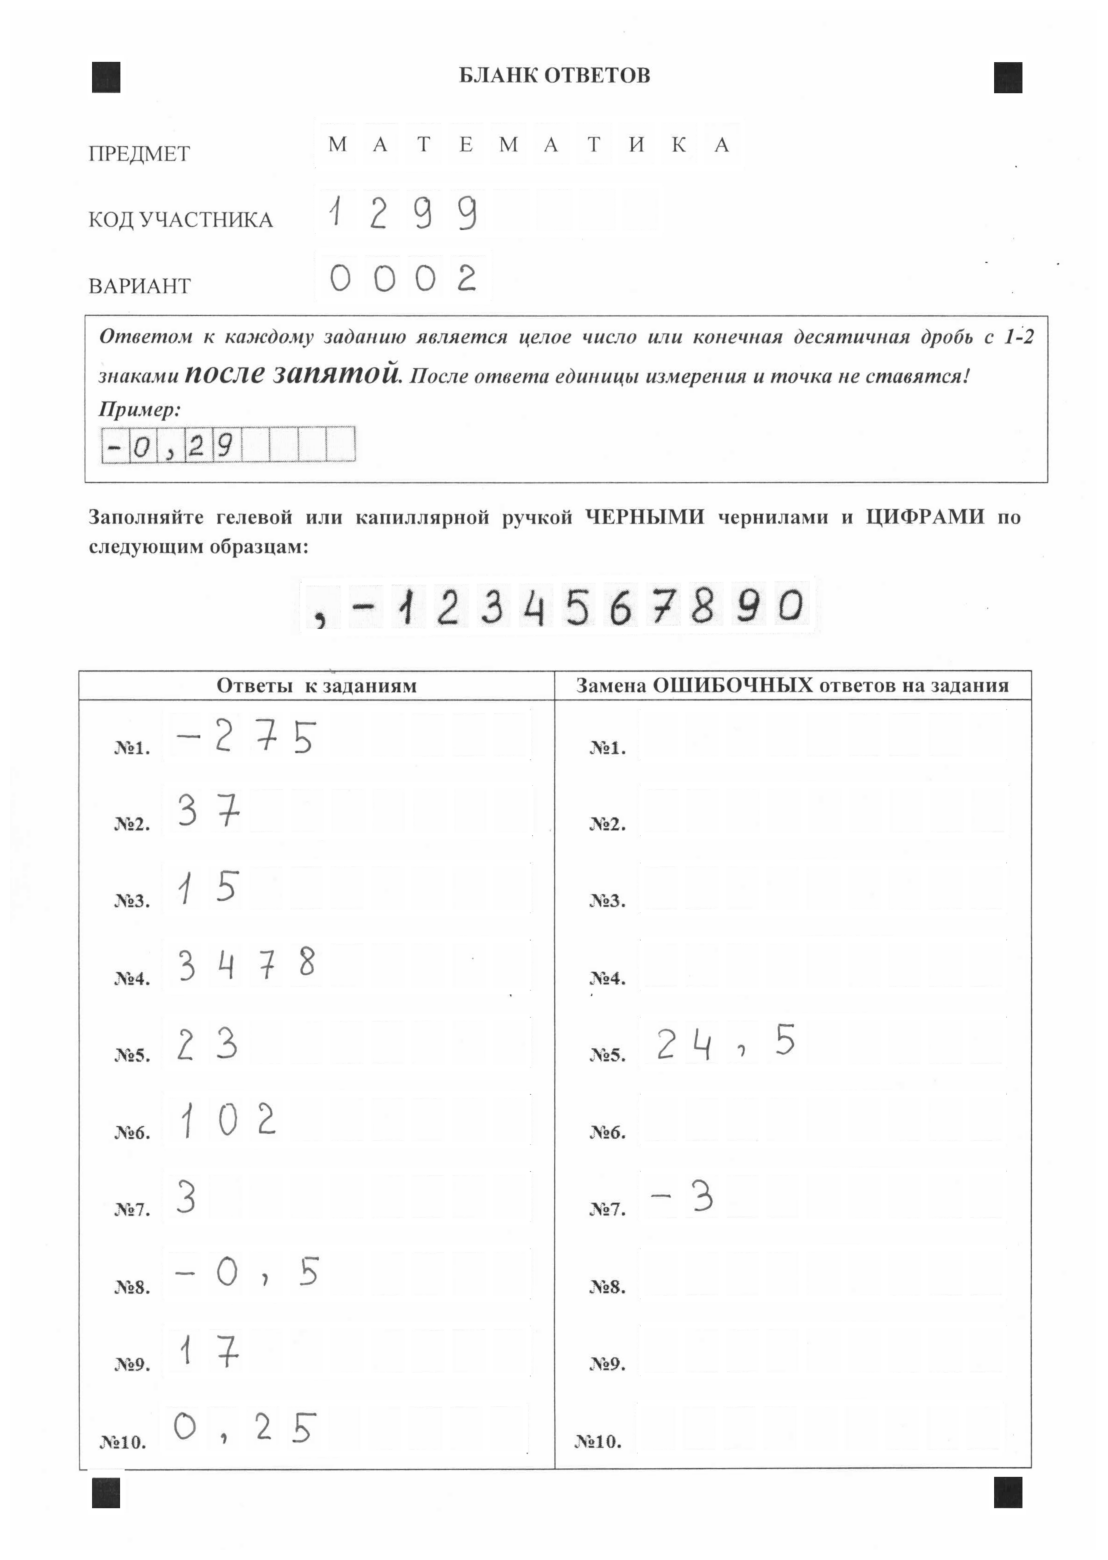

1389


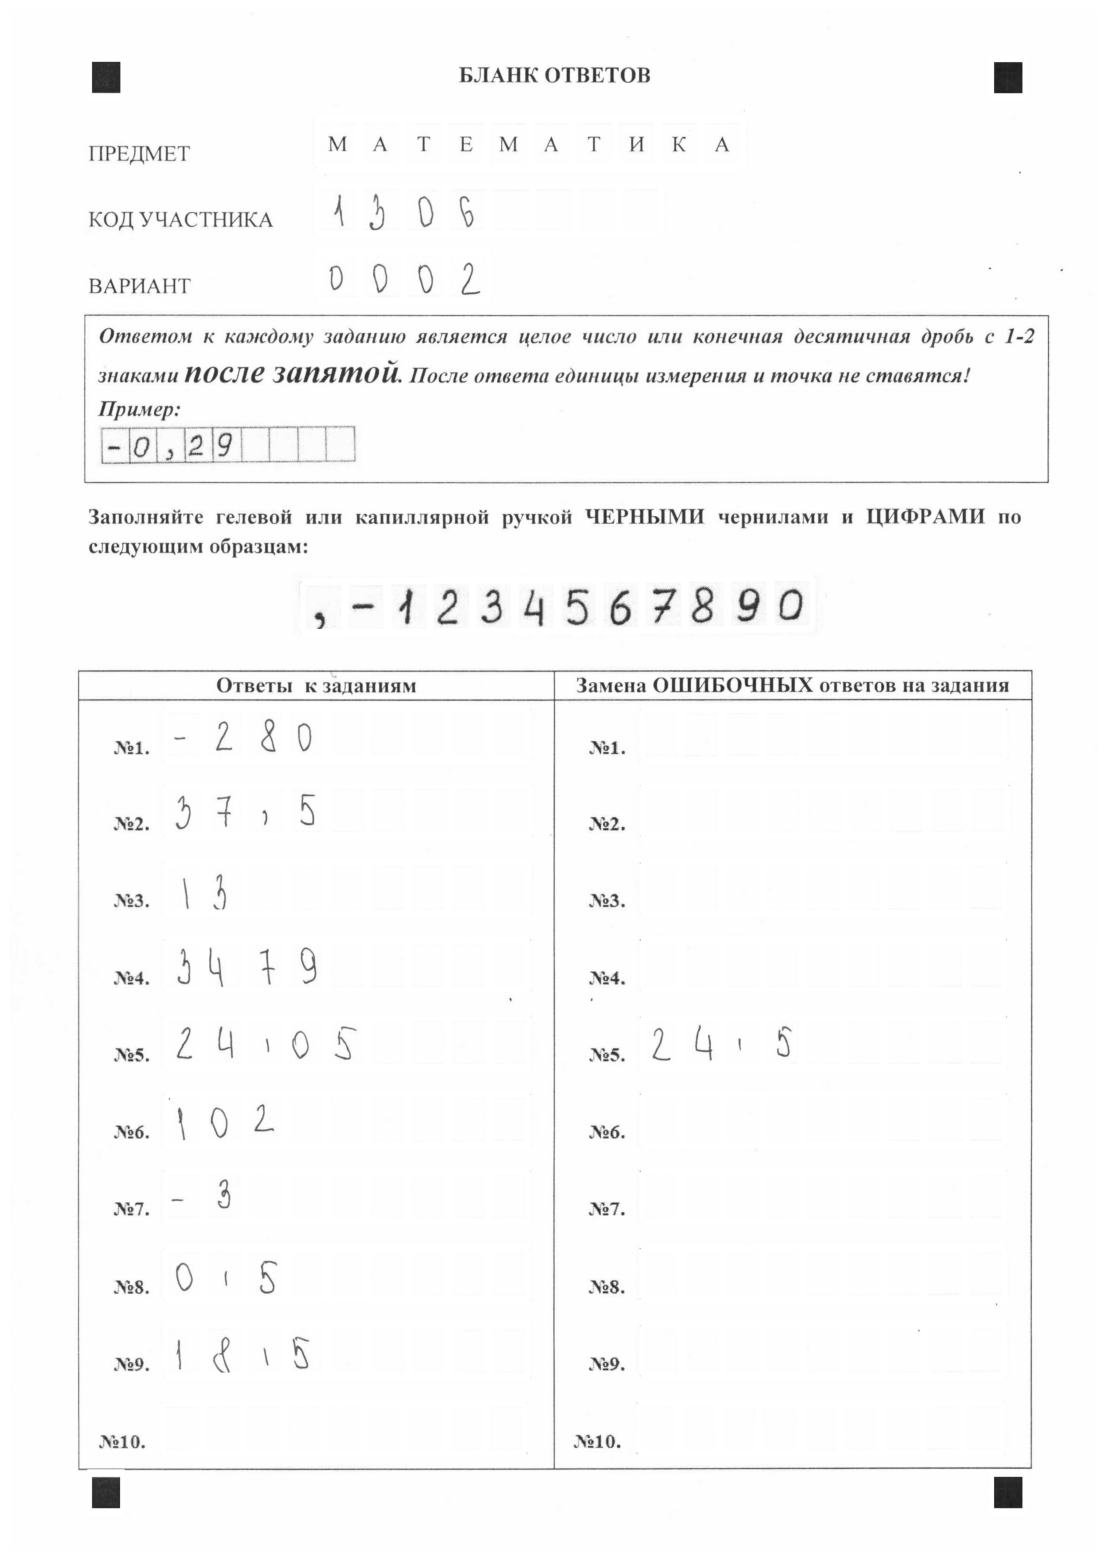

In [8]:
for i in range(1, 11):
    cur_pic = cv2.imread("test_pics/valid_format/page-{}.jpg".format(i), cv2.IMREAD_GRAYSCALE)
    template_pic_contours = cv2.imread("test_pics/template_2.jpg", cv2.IMREAD_GRAYSCALE)
    template_pic_aligned = cv2.imread("test_pics/template.jpg", cv2.IMREAD_GRAYSCALE)



    contours_valid, output = get_contours(template_pic_contours)

    aligned_pic = get_aligned_pic(template_pic_aligned, cur_pic)

    aligned_pic = cv2.cvtColor(aligned_pic, cv2.COLOR_GRAY2BGR)
    aligned_pic_plot = aligned_pic.copy()
    # for contour in contours_valid:
    #     x, y, w, h = cv2.boundingRect(contour)
    #     cv2.rectangle(aligned_pic_plot, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # plt.figure(figsize=(20, 20))
    # plt.imshow(cv2.cvtColor(aligned_pic_plot, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()

    image_2 = remove_cells_lines(aligned_pic, contours_valid)

    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [5]:
aligned_pic.shape

(5051, 3571, 3)

In [6]:
len(contours_valid)

218

TypeError: Image data of dtype object cannot be converted to float

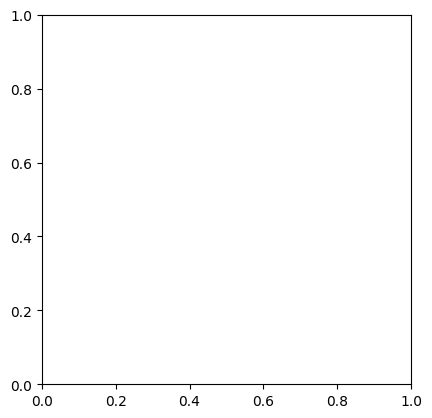

In [8]:
plt.imshow(image_2)

(-0.5, 3570.5, 5050.5, -0.5)

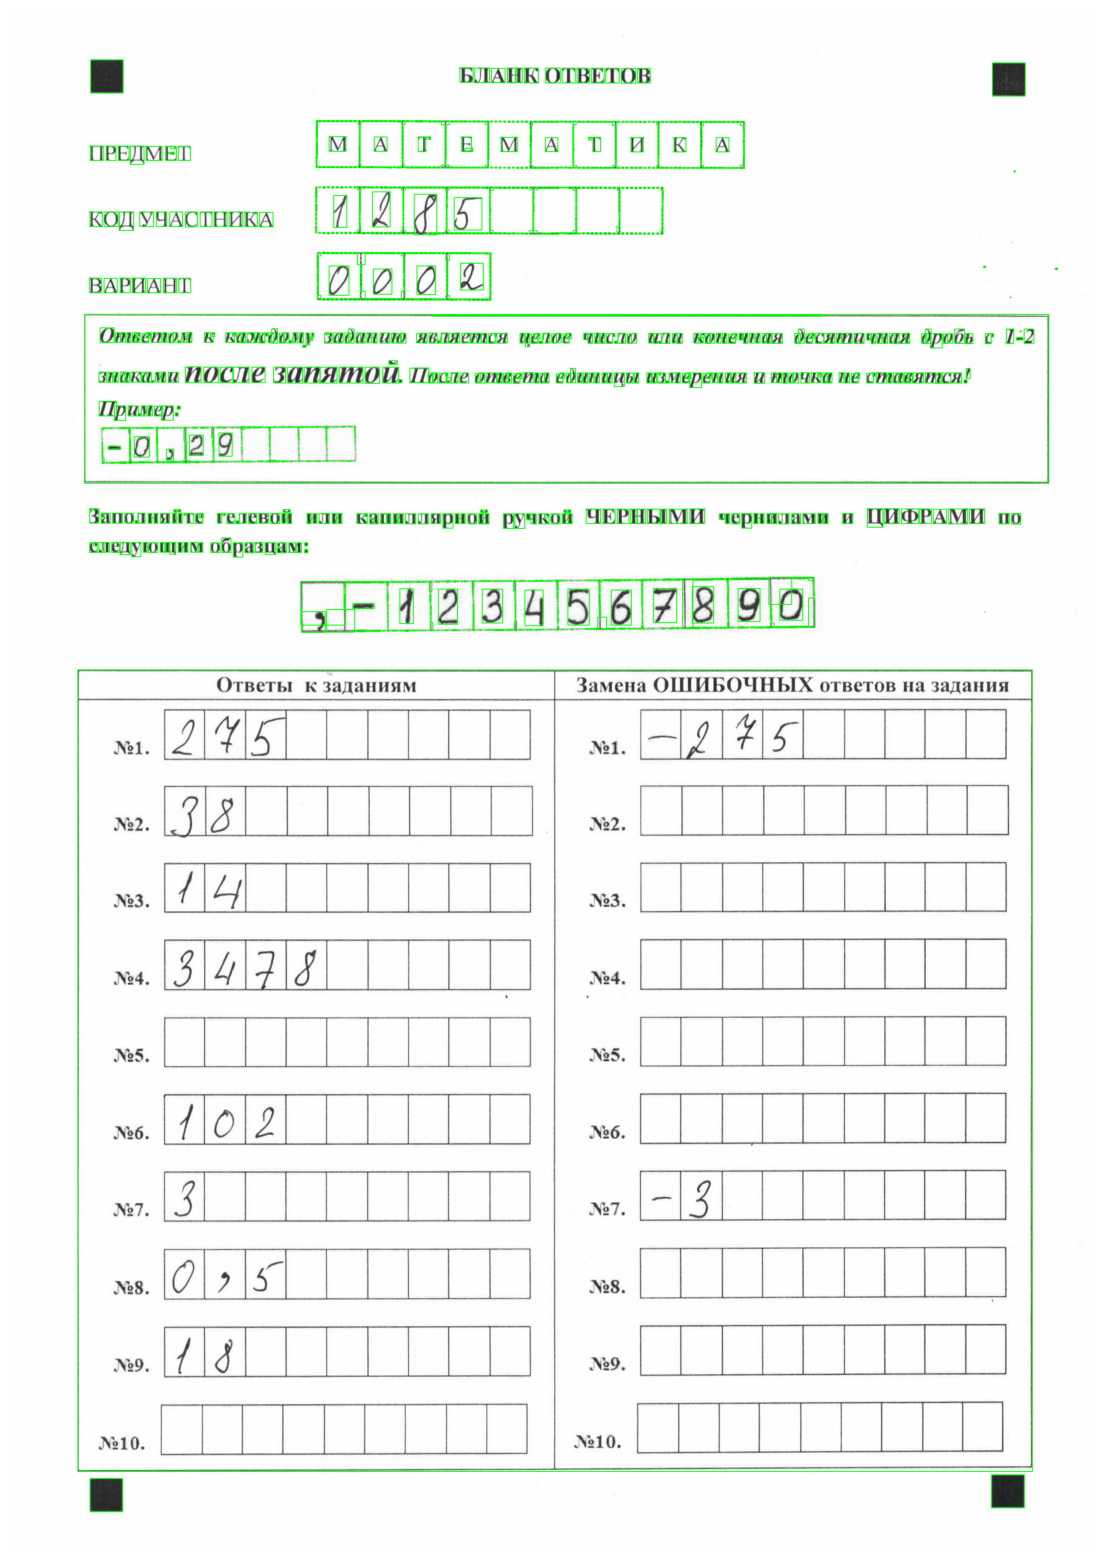

In [46]:
def detect_symbol_in_cell(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

symbol_contours = detect_symbol_in_cell(aligned_pic)
aligned_pic_plot = aligned_pic.copy()
for contour in symbol_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(aligned_pic_plot, (x, y), (x + w, y + h), (0, 255, 0), 2)


plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(aligned_pic_plot, cv2.COLOR_BGR2RGB))
plt.axis('off')



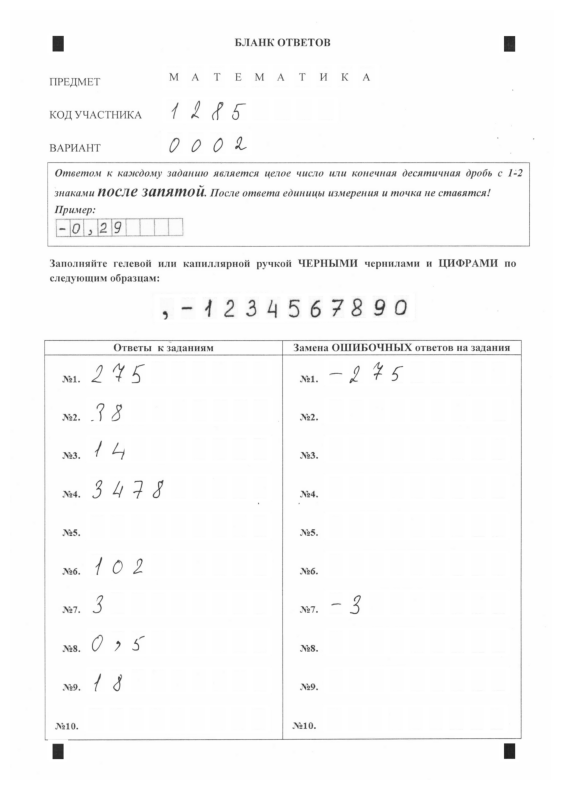

In [64]:
def remove_cells_lines(image, contours_valid):
    for contour in contours_valid:
        x, y, w, h = cv2.boundingRect(contour)
        scale = 20
        scale_2 = 10
        scale_3 = 5
        image[y - scale : y + scale_3, x - scale_2 : x + w + scale_2] = 255 # нижняя горизонтальная линия
        image[y + h - scale_3 : y + h + scale, x - scale_2 : x + w + scale_2] = 255 # верхняя горизонтальная лини
        image[y - scale_2 : y + h + scale_2, x - scale : x + scale] = 255 # левая вертикальная линия
        image[y - scale_2 : y + h + scale_2, x + w - scale : x + w + scale] = 255 # правая вертикальная линия

    return image
    
image_2 = remove_cells_lines(aligned_pic, contours_valid)

plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [53]:
contours_valid[0].shape

(26, 1, 2)

In [58]:
len(contours_valid)


218